# Plot coverage distribution

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect

# Plots
histBinNum = 30 # Histograms
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum']

## Load data

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', 1000)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 200


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str) and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values(['X', 'Y', 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'position'] = 'corner' if config == 0 else 'border' if config == 1 else 'center'
    count += 1
scalars_wide = scalars_wide[['position', 'repetition', *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Histograms

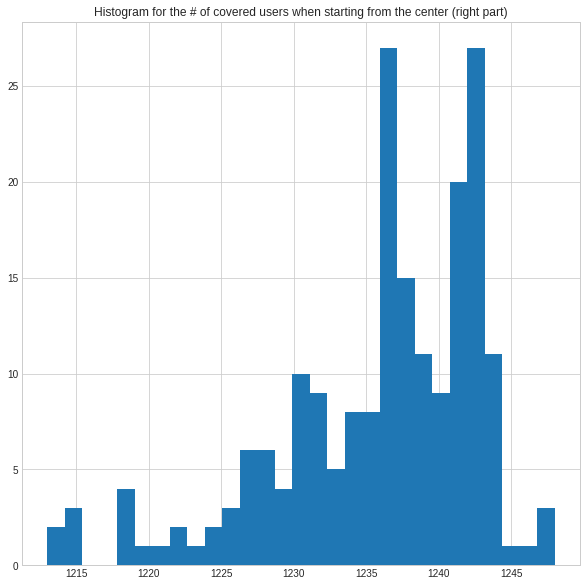

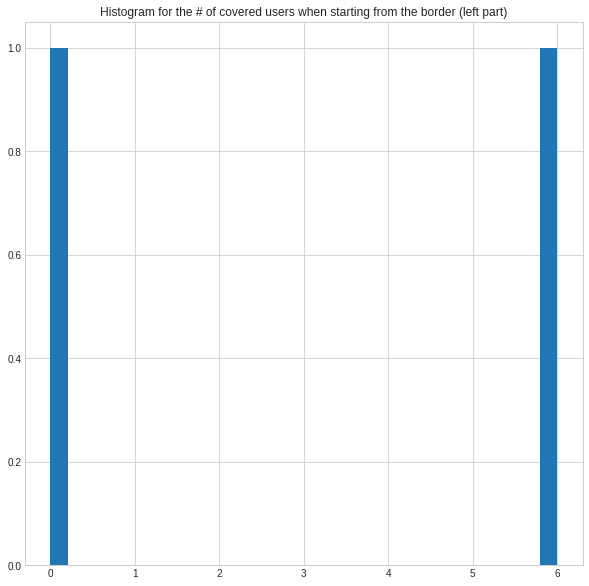

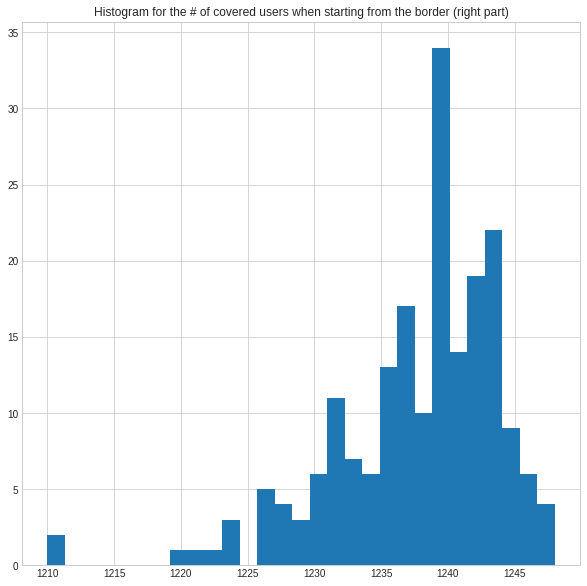

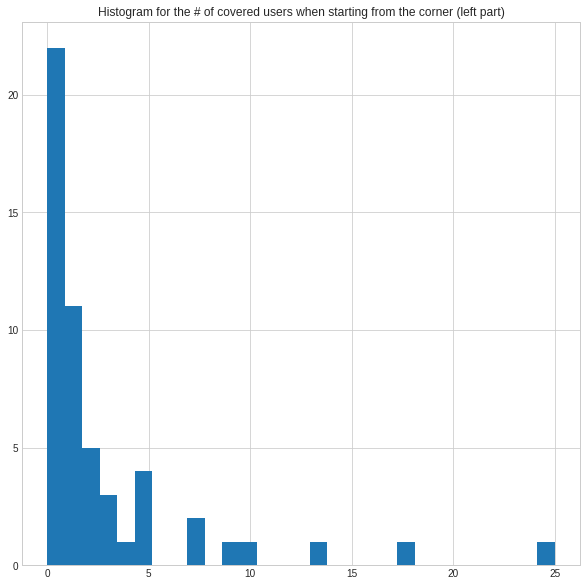

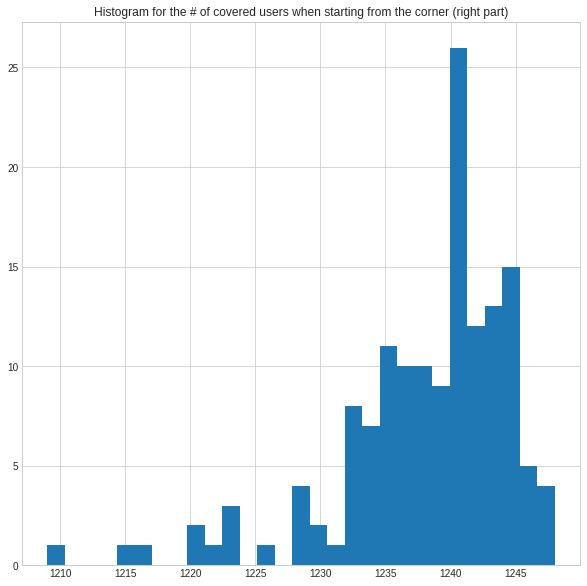

In [6]:
for pos in ['center', 'border', 'corner']:
    for part in ['left', 'right']:
        current = scalars_wide[scalars_wide['position'] == pos]
        if part == 'left':
            current = current[current['coveredUsersPercent'] < 0.5]
        else:
            current = current[current['coveredUsersPercent'] >= 0.5]
        if len(current.index) == 0:
            continue
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        minval = current['Floorplan.coveredUsers:sum'].min()
        maxval = current['Floorplan.coveredUsers:sum'].max()
        if minval == maxval:
            minval -= 1
            maxval += 1
        plt.hist(current['Floorplan.coveredUsers:sum'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
        plt.title('Histogram for the # of covered users when starting from the ' + pos + ' (' + part + ' part)')
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + pos + '-' + part + '-hist.png')
        plt.show()

## Stats

In [7]:
for pos in ['center', 'border', 'corner']:
    print('Stats for position', pos)
    display(scalars_wide[scalars_wide['position'] == pos].describe()[['Floorplan.coveredUsers:sum', 'coveredUsersPercent']])

Stats for position center


qname,Floorplan.coveredUsers:sum,coveredUsersPercent
count,200.000000,200.000000
mean,1235.785000,0.989420
std,7.084471,0.005672
min,1213.000000,0.971177
25%,1232.000000,0.986389
50%,1237.000000,0.990392
75%,1241.000000,0.993595
max,1248.000000,0.999199


Stats for position border


qname,Floorplan.coveredUsers:sum,coveredUsersPercent
count,200.000000,200.000000
mean,1225.345000,0.981061
std,123.317566,0.098733
min,0.000000,0.000000
25%,1234.000000,0.987990
50%,1239.000000,0.991994
75%,1242.000000,0.994396
max,1248.000000,0.999199


Stats for position corner


qname,Floorplan.coveredUsers:sum,coveredUsersPercent
count,200.000000,200.000000
mean,910.640000,0.729095
std,546.580205,0.437614
min,0.000000,0.000000
25%,12.250000,0.009808
50%,1236.000000,0.989592
75%,1241.000000,0.993595
max,1248.000000,0.999199
